In [1]:
import sys
sys.path.append('../code')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from sklearn.model_selection import ShuffleSplit
import pickle

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0")
#device = torch.device('cpu')

torch.backends.cudnn.benchmark = True

import contrastive_functions

In [2]:
num_fold = 10
num_neuron_results_dict = {'num_fold': num_fold}
for noise_fold in range(num_fold): 
    data_dict = contrastive_functions.get_marker_decode_dataframes(noise_fold = noise_fold, cam_idx=1)
    wrist_df = data_dict['wrist_df']
    task_neural_df = data_dict['task_neural_df']
    notask_neural_df = data_dict['notask_neural_df']
    metadata = data_dict['metadata']
    cv_dict = data_dict['cv_dict']

    notask_time_neural_mask = notask_neural_df['unit'] != 'time'
    notask_neural_df = notask_neural_df[notask_time_neural_mask]

    time_wrist_mask = wrist_df['name'] != 'time'
    wrist_df = wrist_df[time_wrist_mask]

    neuron_list = notask_neural_df['unit'].unique()

    neural_offset = 10 # try 50-150 ms offset

    window_size = 70

    # neural_offset = 2 # try 50-150 ms offset

    # window_size = 10

    label_col = 'layout'

    data_arrays, generators = contrastive_functions.make_generators(
        wrist_df, notask_neural_df, neural_offset, cv_dict, metadata, exclude_neural=None,
        window_size=window_size, flip_outputs=True, batch_size=1000, label_col='layout')

    # Unpack tuple into variables
    training_set, validation_set, testing_set = data_arrays
    training_generator, training_eval_generator, validation_generator, testing_generator = generators

    X_train_data = training_set[:][0][:,-1,:].detach().cpu().numpy()
    y_train_data = training_set[:][1][:,-1,:].detach().cpu().numpy()

    X_test_data = testing_set[:][0][:,-1,:].detach().cpu().numpy()
    y_test_data = testing_set[:][1][:,-1,:].detach().cpu().numpy()

    test_labels = testing_set[:][2].detach().cpu().numpy()

    unit_corr_array = list()
    for unit_idx in range(X_train_data.shape[1]):
        unit_corr = list()
        for mrk_idx in range(y_test_data.shape[1]):
            unit_corr.append(np.abs(np.corrcoef(X_train_data[:, unit_idx], y_train_data[:, mrk_idx])[0,1]))
        unit_corr_array.append(np.array(unit_corr))

    unit_corr_array = np.vstack(unit_corr_array)

    sort_indices = np.argsort(np.mean(unit_corr_array, axis=1))
    sorted_neuron_list = neuron_list[sort_indices]

    func_dict = {'rnn': contrastive_functions.run_rnn}
    # func_dict = {'wiener': contrastive_functions.run_wiener, 'rnn': contrastive_functions.run_rnn}
    fpath = '../data/SPK20220308/neuron_num_results/'

    num_neuron_list = [4,6,10,14,20,30]
    # num_neuron_list = [2,4,6,8,10]
    # num_neuron_list = [2,4,6,8,10,12,14,16,18,20,25,30,35,40]

    num_neuron_results_dict[f'fold_{noise_fold}'] = {'sorted_neuron_list': sorted_neuron_list, 'num_neuron_list': num_neuron_list}
    for num_neurons in num_neuron_list:

        neuron_subset = sorted_neuron_list[:num_neurons]
        # neuron_subset = sorted_neuron_list[-num_neurons:-1]

        # Filter neural_df with task info to random subset of neurons
        task_unit_mask = np.in1d(task_neural_df['unit'].values, neuron_subset)
        layout_mask = task_neural_df['unit'].str.contains(pat='layout')

        task_neural_df_filtered = task_neural_df[np.logical_or.reduce([task_unit_mask, layout_mask])].reset_index(drop=True)

        # Filter neural_df without task info to random subset of neurons
        notask_unit_mask = np.in1d(notask_neural_df['unit'].values, neuron_subset)
        notask_neural_df_filtered = notask_neural_df[np.logical_or.reduce([notask_unit_mask])].reset_index(drop=True)

        df_dict = {'task': {'df': task_neural_df_filtered, 'task_info': True, 'num_cat': 4, 'flip_outputs': True}, # num_cat = number of categorical features
                    'notask': {'df': notask_neural_df_filtered, 'task_info': False, 'num_cat': 0, 'flip_outputs': True}}
        

        decode_results = dict()
        for func_name, func in func_dict.items():
            decode_results[func_name] = dict()
            for df_type, pred_df in df_dict.items():
                print(f'{func_name}_{df_type} num_neurons: {num_neurons}, fold:{noise_fold}')
                model, res_dict = func(wrist_df, pred_df['df'], neural_offset, cv_dict, metadata, task_info=pred_df['task_info'],
                                        window_size=window_size, num_cat=pred_df['num_cat'], label_col=label_col, flip_outputs=pred_df['flip_outputs'])

                decode_results[func_name][df_type] = res_dict

                # Save results on every loop in case early stop
                num_neuron_results_dict[f'fold_{noise_fold}'][f'num_neuron_{num_neurons}'] = decode_results

                #Save metadata
                output = open(f'{fpath}neuron_sort_results_10fold_cosinedist_2back.pkl', 'wb')
                pickle.dump(num_neuron_results_dict, output)
                output.close()

/home/nick/Donoghue_lab/ncm_2023/notebooks/../code/contrastive_functions.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neural_temp_df['rates'][unit_mask] = noise_data
/home/nick/Donoghue_lab/ncm_2023/notebooks/../code/contrastive_functions.py:345: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wrist_temp_df['posData'][unit_mask] = noise_data
/home/nick/Donoghue_lab/ncm_2023/notebooks/../code/contrastive_functions.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

rnn_task num_neurons: 4, fold:0
*******..*
Epoch: 10/1000 ... Train Loss: 1.6236  ... Validation Loss: 1.5962
...... Early Stop; Min Epoch: 10
rnn_notask num_neurons: 4, fold:0
***.******
Epoch: 10/1000 ... Train Loss: 0.9816  ... Validation Loss: 0.9792
*...... Early Stop; Min Epoch: 11
rnn_task num_neurons: 6, fold:0
*****...**
Epoch: 10/1000 ... Train Loss: 1.4563  ... Validation Loss: 1.4827
*.*.*..**.
Epoch: 20/1000 ... Train Loss: 1.2108  ... Validation Loss: 1.3540
..**.*****
Epoch: 30/1000 ... Train Loss: 1.0829  ... Validation Loss: 1.2223
...... Early Stop; Min Epoch: 30
rnn_notask num_neurons: 6, fold:0
********.*
Epoch: 10/1000 ... Train Loss: 0.6717  ... Validation Loss: 0.7681
.****.....
Epoch: 20/1000 ... Train Loss: 0.4773  ... Validation Loss: 0.6912
. Early Stop; Min Epoch: 15
rnn_task num_neurons: 10, fold:0
****..****
Epoch: 10/1000 ... Train Loss: 1.1742  ... Validation Loss: 1.3915
**..**..**
Epoch: 20/1000 ... Train Loss: 0.9959  ... Validation Loss: 1.3256
**...

/home/nick/Donoghue_lab/ncm_2023/notebooks/../code/contrastive_functions.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neural_temp_df['rates'][unit_mask] = noise_data
/home/nick/Donoghue_lab/ncm_2023/notebooks/../code/contrastive_functions.py:345: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wrist_temp_df['posData'][unit_mask] = noise_data
/home/nick/Donoghue_lab/ncm_2023/notebooks/../code/contrastive_functions.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

rnn_task num_neurons: 4, fold:1
********.*
Epoch: 10/1000 ... Train Loss: 1.8552  ... Validation Loss: 1.7451
*****...*.
Epoch: 20/1000 ... Train Loss: 1.6512  ... Validation Loss: 1.6283
..*.....*.
Epoch: 30/1000 ... Train Loss: 1.5798  ... Validation Loss: 1.6383
..... Early Stop; Min Epoch: 29
rnn_notask num_neurons: 4, fold:1
**********
Epoch: 10/1000 ... Train Loss: 1.1652  ... Validation Loss: 1.0668
.*****.*..
Epoch: 20/1000 ... Train Loss: 0.9552  ... Validation Loss: 0.9607
.... Early Stop; Min Epoch: 18
rnn_task num_neurons: 6, fold:1
**********
Epoch: 10/1000 ... Train Loss: 1.7885  ... Validation Loss: 1.6164
***...... Early Stop; Min Epoch: 13
rnn_notask num_neurons: 6, fold:1
**********
Epoch: 10/1000 ... Train Loss: 1.1403  ... Validation Loss: 1.0284
***.**.***
Epoch: 20/1000 ... Train Loss: 0.6977  ... Validation Loss: 0.7245
*...... Early Stop; Min Epoch: 21
rnn_task num_neurons: 10, fold:1
**********
Epoch: 10/1000 ... Train Loss: 1.7424  ... Validation Loss: 1.6409


/home/nick/Donoghue_lab/ncm_2023/notebooks/../code/contrastive_functions.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neural_temp_df['rates'][unit_mask] = noise_data
/home/nick/Donoghue_lab/ncm_2023/notebooks/../code/contrastive_functions.py:345: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wrist_temp_df['posData'][unit_mask] = noise_data
/home/nick/Donoghue_lab/ncm_2023/notebooks/../code/contrastive_functions.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

rnn_task num_neurons: 4, fold:2
**********
Epoch: 10/1000 ... Train Loss: 1.8370  ... Validation Loss: 1.7244
******.*..
Epoch: 20/1000 ... Train Loss: 1.6465  ... Validation Loss: 1.6550
***..*....
Epoch: 30/1000 ... Train Loss: 1.5724  ... Validation Loss: 1.6561
.. Early Stop; Min Epoch: 26
rnn_notask num_neurons: 4, fold:2
**********
Epoch: 10/1000 ... Train Loss: 1.1672  ... Validation Loss: 1.0714
*******...
Epoch: 20/1000 ... Train Loss: 1.0085  ... Validation Loss: 1.0078
..*...... Early Stop; Min Epoch: 23
rnn_task num_neurons: 6, fold:2
**********
Epoch: 10/1000 ... Train Loss: 1.7803  ... Validation Loss: 1.6337
****......
Epoch: 20/1000 ... Train Loss: 1.4706  ... Validation Loss: 1.5662
 Early Stop; Min Epoch: 14
rnn_notask num_neurons: 6, fold:2
****.*****
Epoch: 10/1000 ... Train Loss: 1.1363  ... Validation Loss: 1.0322
******..*.
Epoch: 20/1000 ... Train Loss: 0.6819  ... Validation Loss: 0.7517
**...... Early Stop; Min Epoch: 22
rnn_task num_neurons: 10, fold:2
******

/home/nick/Donoghue_lab/ncm_2023/notebooks/../code/contrastive_functions.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neural_temp_df['rates'][unit_mask] = noise_data
/home/nick/Donoghue_lab/ncm_2023/notebooks/../code/contrastive_functions.py:345: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wrist_temp_df['posData'][unit_mask] = noise_data
/home/nick/Donoghue_lab/ncm_2023/notebooks/../code/contrastive_functions.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

rnn_task num_neurons: 4, fold:3
*******...
Epoch: 10/1000 ... Train Loss: 1.8440  ... Validation Loss: 1.7532
******.*..
Epoch: 20/1000 ... Train Loss: 1.6562  ... Validation Loss: 1.6290
.*...... Early Stop; Min Epoch: 22
rnn_notask num_neurons: 4, fold:3
**.*.*****
Epoch: 10/1000 ... Train Loss: 1.1825  ... Validation Loss: 1.0697
*********.
Epoch: 20/1000 ... Train Loss: 0.9637  ... Validation Loss: 0.9759
..... Early Stop; Min Epoch: 19
rnn_task num_neurons: 6, fold:3
**********
Epoch: 10/1000 ... Train Loss: 1.7928  ... Validation Loss: 1.6387
***...... Early Stop; Min Epoch: 13
rnn_notask num_neurons: 6, fold:3
**********
Epoch: 10/1000 ... Train Loss: 1.1342  ... Validation Loss: 1.0156
***..*....
Epoch: 20/1000 ... Train Loss: 0.7878  ... Validation Loss: 0.9760
.. Early Stop; Min Epoch: 16
rnn_task num_neurons: 10, fold:3
**********
Epoch: 10/1000 ... Train Loss: 1.7361  ... Validation Loss: 1.6123
**.....**.
Epoch: 20/1000 ... Train Loss: 1.3186  ... Validation Loss: 1.5116
.

/home/nick/Donoghue_lab/ncm_2023/notebooks/../code/contrastive_functions.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neural_temp_df['rates'][unit_mask] = noise_data
/home/nick/Donoghue_lab/ncm_2023/notebooks/../code/contrastive_functions.py:345: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wrist_temp_df['posData'][unit_mask] = noise_data
/home/nick/Donoghue_lab/ncm_2023/notebooks/../code/contrastive_functions.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

rnn_task num_neurons: 4, fold:4
********.*
Epoch: 10/1000 ... Train Loss: 1.8433  ... Validation Loss: 1.7329
*********.
Epoch: 20/1000 ... Train Loss: 1.6576  ... Validation Loss: 1.6224
..... Early Stop; Min Epoch: 19
rnn_notask num_neurons: 4, fold:4
**.**.***.
Epoch: 10/1000 ... Train Loss: 1.1719  ... Validation Loss: 1.0826
*********.
Epoch: 20/1000 ... Train Loss: 1.0035  ... Validation Loss: 1.0139
*...... Early Stop; Min Epoch: 21
rnn_task num_neurons: 6, fold:4
**********
Epoch: 10/1000 ... Train Loss: 1.7627  ... Validation Loss: 1.5999
**...... Early Stop; Min Epoch: 12
rnn_notask num_neurons: 6, fold:4
***.******
Epoch: 10/1000 ... Train Loss: 1.1445  ... Validation Loss: 1.0265
*****.****
Epoch: 20/1000 ... Train Loss: 0.7187  ... Validation Loss: 0.7392
.**...... Early Stop; Min Epoch: 23
rnn_task num_neurons: 10, fold:4
**********
Epoch: 10/1000 ... Train Loss: 1.7742  ... Validation Loss: 1.6397
**...... Early Stop; Min Epoch: 12
rnn_notask num_neurons: 10, fold:4
****

/home/nick/Donoghue_lab/ncm_2023/notebooks/../code/contrastive_functions.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neural_temp_df['rates'][unit_mask] = noise_data
/home/nick/Donoghue_lab/ncm_2023/notebooks/../code/contrastive_functions.py:345: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wrist_temp_df['posData'][unit_mask] = noise_data
/home/nick/Donoghue_lab/ncm_2023/notebooks/../code/contrastive_functions.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

rnn_task num_neurons: 4, fold:5
********..
Epoch: 10/1000 ... Train Loss: 1.8399  ... Validation Loss: 1.7401
****.*....
Epoch: 20/1000 ... Train Loss: 1.6687  ... Validation Loss: 1.6621
*...... Early Stop; Min Epoch: 21
rnn_notask num_neurons: 4, fold:5
**********
Epoch: 10/1000 ... Train Loss: 1.1861  ... Validation Loss: 1.0743
*******...
Epoch: 20/1000 ... Train Loss: 0.9490  ... Validation Loss: 1.0325
... Early Stop; Min Epoch: 17
rnn_task num_neurons: 6, fold:5
**********
Epoch: 10/1000 ... Train Loss: 1.8205  ... Validation Loss: 1.6739
****...**.
Epoch: 20/1000 ... Train Loss: 1.4720  ... Validation Loss: 1.5438
.*..******
Epoch: 30/1000 ... Train Loss: 1.3901  ... Validation Loss: 1.4231
*.**......
Epoch: 40/1000 ... Train Loss: 1.2627  ... Validation Loss: 1.3947
 Early Stop; Min Epoch: 34
rnn_notask num_neurons: 6, fold:5
**.*******
Epoch: 10/1000 ... Train Loss: 1.1378  ... Validation Loss: 1.0120
****.***.*
Epoch: 20/1000 ... Train Loss: 0.7452  ... Validation Loss: 0.78

/home/nick/Donoghue_lab/ncm_2023/notebooks/../code/contrastive_functions.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neural_temp_df['rates'][unit_mask] = noise_data
/home/nick/Donoghue_lab/ncm_2023/notebooks/../code/contrastive_functions.py:345: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wrist_temp_df['posData'][unit_mask] = noise_data
/home/nick/Donoghue_lab/ncm_2023/notebooks/../code/contrastive_functions.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

rnn_task num_neurons: 4, fold:6
********..
Epoch: 10/1000 ... Train Loss: 1.8432  ... Validation Loss: 1.7538
*******...
Epoch: 20/1000 ... Train Loss: 1.6637  ... Validation Loss: 1.6512
... Early Stop; Min Epoch: 17
rnn_notask num_neurons: 4, fold:6
**********
Epoch: 10/1000 ... Train Loss: 1.1608  ... Validation Loss: 1.0669
*.*.**..*.
Epoch: 20/1000 ... Train Loss: 1.0050  ... Validation Loss: 1.0189
*...... Early Stop; Min Epoch: 21
rnn_task num_neurons: 6, fold:6
********.*
Epoch: 10/1000 ... Train Loss: 1.8139  ... Validation Loss: 1.6657
**.*......
Epoch: 20/1000 ... Train Loss: 1.4848  ... Validation Loss: 1.5426
 Early Stop; Min Epoch: 14
rnn_notask num_neurons: 6, fold:6
**.*.*****
Epoch: 10/1000 ... Train Loss: 1.1207  ... Validation Loss: 1.0125
*****.****
Epoch: 20/1000 ... Train Loss: 0.7285  ... Validation Loss: 0.7421
***...... Early Stop; Min Epoch: 23
rnn_task num_neurons: 10, fold:6
**********
Epoch: 10/1000 ... Train Loss: 1.7611  ... Validation Loss: 1.6562
**....

/home/nick/Donoghue_lab/ncm_2023/notebooks/../code/contrastive_functions.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neural_temp_df['rates'][unit_mask] = noise_data
/home/nick/Donoghue_lab/ncm_2023/notebooks/../code/contrastive_functions.py:345: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wrist_temp_df['posData'][unit_mask] = noise_data
/home/nick/Donoghue_lab/ncm_2023/notebooks/../code/contrastive_functions.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

rnn_task num_neurons: 4, fold:7
********.*
Epoch: 10/1000 ... Train Loss: 1.8490  ... Validation Loss: 1.7451
*****.*..*
Epoch: 20/1000 ... Train Loss: 1.6626  ... Validation Loss: 1.6374
.*...... Early Stop; Min Epoch: 22
rnn_notask num_neurons: 4, fold:7
*****.***.
Epoch: 10/1000 ... Train Loss: 1.1702  ... Validation Loss: 1.0690
.********.
Epoch: 20/1000 ... Train Loss: 0.9486  ... Validation Loss: 0.9620
..... Early Stop; Min Epoch: 19
rnn_task num_neurons: 6, fold:7
**********
Epoch: 10/1000 ... Train Loss: 1.7822  ... Validation Loss: 1.6272
***..*....
Epoch: 20/1000 ... Train Loss: 1.4608  ... Validation Loss: 1.5320
.. Early Stop; Min Epoch: 16
rnn_notask num_neurons: 6, fold:7
**********
Epoch: 10/1000 ... Train Loss: 1.1335  ... Validation Loss: 1.0287
********..
Epoch: 20/1000 ... Train Loss: 0.7806  ... Validation Loss: 0.8277
...******.
Epoch: 30/1000 ... Train Loss: 0.6540  ... Validation Loss: 0.7814
...*.*****
Epoch: 40/1000 ... Train Loss: 0.5766  ... Validation Loss:

/home/nick/Donoghue_lab/ncm_2023/notebooks/../code/contrastive_functions.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neural_temp_df['rates'][unit_mask] = noise_data
/home/nick/Donoghue_lab/ncm_2023/notebooks/../code/contrastive_functions.py:345: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wrist_temp_df['posData'][unit_mask] = noise_data
/home/nick/Donoghue_lab/ncm_2023/notebooks/../code/contrastive_functions.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

rnn_task num_neurons: 4, fold:8
********.*
Epoch: 10/1000 ... Train Loss: 1.8459  ... Validation Loss: 1.7323
***.***...
Epoch: 20/1000 ... Train Loss: 1.6542  ... Validation Loss: 1.6209
... Early Stop; Min Epoch: 17
rnn_notask num_neurons: 4, fold:8
****.****.
Epoch: 10/1000 ... Train Loss: 1.1815  ... Validation Loss: 1.0679
..****.***
Epoch: 20/1000 ... Train Loss: 1.0031  ... Validation Loss: 0.9710
**...... Early Stop; Min Epoch: 22
rnn_task num_neurons: 6, fold:8
********.*
Epoch: 10/1000 ... Train Loss: 1.8098  ... Validation Loss: 1.6756
***...... Early Stop; Min Epoch: 13
rnn_notask num_neurons: 6, fold:8
**********
Epoch: 10/1000 ... Train Loss: 1.1415  ... Validation Loss: 1.0102
*********.
Epoch: 20/1000 ... Train Loss: 0.6928  ... Validation Loss: 0.7477
**...... Early Stop; Min Epoch: 22
rnn_task num_neurons: 10, fold:8
********.*
Epoch: 10/1000 ... Train Loss: 1.7625  ... Validation Loss: 1.6426
**...... Early Stop; Min Epoch: 12
rnn_notask num_neurons: 10, fold:8
*****

/home/nick/Donoghue_lab/ncm_2023/notebooks/../code/contrastive_functions.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neural_temp_df['rates'][unit_mask] = noise_data
/home/nick/Donoghue_lab/ncm_2023/notebooks/../code/contrastive_functions.py:345: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wrist_temp_df['posData'][unit_mask] = noise_data
/home/nick/Donoghue_lab/ncm_2023/notebooks/../code/contrastive_functions.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

rnn_task num_neurons: 4, fold:9
********..
Epoch: 10/1000 ... Train Loss: 1.8576  ... Validation Loss: 1.7587
******..*.
Epoch: 20/1000 ... Train Loss: 1.6546  ... Validation Loss: 1.6548
**...... Early Stop; Min Epoch: 22
rnn_notask num_neurons: 4, fold:9
*********.
Epoch: 10/1000 ... Train Loss: 1.1809  ... Validation Loss: 1.0743
*****....*
Epoch: 20/1000 ... Train Loss: 0.9972  ... Validation Loss: 1.0145
...... Early Stop; Min Epoch: 20
rnn_task num_neurons: 6, fold:9
**********
Epoch: 10/1000 ... Train Loss: 1.8089  ... Validation Loss: 1.6610
***...... Early Stop; Min Epoch: 13
rnn_notask num_neurons: 6, fold:9
**********
Epoch: 10/1000 ... Train Loss: 1.1243  ... Validation Loss: 1.0230
*****.****
Epoch: 20/1000 ... Train Loss: 0.6983  ... Validation Loss: 0.7408
...... Early Stop; Min Epoch: 20
rnn_task num_neurons: 10, fold:9
**********
Epoch: 10/1000 ... Train Loss: 1.7707  ... Validation Loss: 1.6554
**...... Early Stop; Min Epoch: 12
rnn_notask num_neurons: 10, fold:9
*.**

In [3]:
decoder_type = 'rnn'
# decoder_type = 'wiener'

task_test_corr = list()
notask_test_corr = list()
for num_neurons in num_neuron_list:
    res_dict = num_neuron_results_dict[f'fold_0'][f'num_neuron_{num_neurons}']
    task_test_corr.append(np.stack(res_dict[decoder_type]['task']['test_corr']))
    notask_test_corr.append(np.stack(res_dict[decoder_type]['notask']['test_corr']))

task_test_corr = np.stack(task_test_corr)
notask_test_corr = np.stack(notask_test_corr)

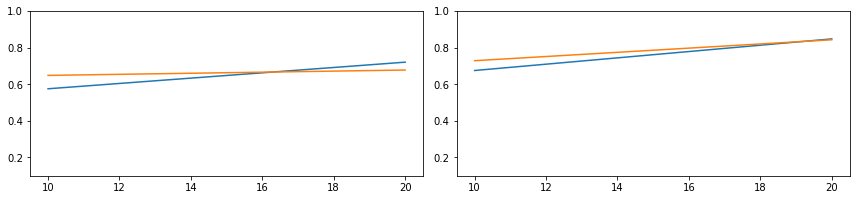

In [4]:
plt.figure(figsize=(12, 8))
for plot_idx in range(2):
    plt.subplot(3,2,plot_idx+1)
    plt.plot(num_neuron_list, notask_test_corr[:, plot_idx])
    plt.plot(num_neuron_list, task_test_corr[:, plot_idx])

    plt.ylim(0.1, 1)


plt.tight_layout()

KeyError: 'num_neuron_10'

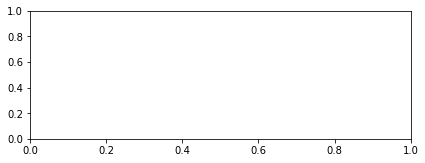

In [5]:
for label_idx in range(1,5):
    label_mask = test_labels == label_idx
    
    plt.figure(figsize=(15,8))
    for mrk_idx in range(2):
        plt.subplot(3,2,mrk_idx+1)

        notask_mse = list()
        task_mse = list()

        for num_neurons in num_neuron_list:
            # notask_error = np.sqrt(np.mean(np.square(num_neuron_results_dict[
            #     f'num_neuron_{num_neurons}']['rnn']['notask']['test_pred'][:,mrk_idx] - y_test_data[:,mrk_idx])))
            # task_error = np.sqrt(np.mean(np.square(num_neuron_results_dict[
            #     f'num_neuron_{num_neurons}']['rnn']['task']['test_pred'][:,mrk_idx] - y_test_data[:,mrk_idx])))

            notask_error = np.mean(np.square(num_neuron_results_dict[
                f'num_neuron_{num_neurons}']['rnn']['notask']['test_pred'][label_mask,mrk_idx] - y_test_data[label_mask,mrk_idx]))
            task_error = np.mean(np.square(num_neuron_results_dict[
                f'num_neuron_{num_neurons}']['rnn']['task']['test_pred'][label_mask,mrk_idx] - y_test_data[label_mask,mrk_idx]))

            notask_mse.append(notask_error)
            task_mse.append(task_error)

        plt.plot(num_neuron_list, notask_mse)
        plt.plot(num_neuron_list, task_mse)
        plt.ylim(0, 1.8)

        plt.suptitle(f'label {label_idx}')



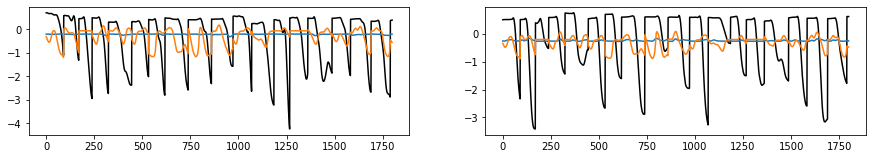

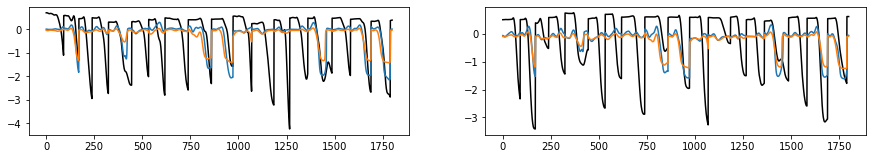

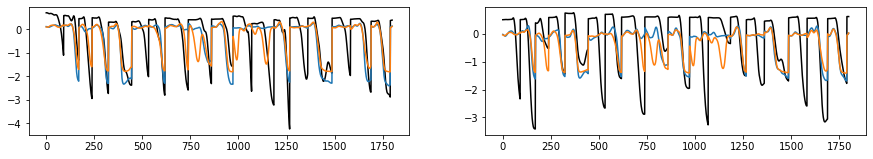

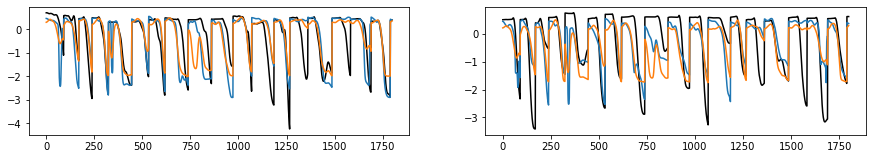

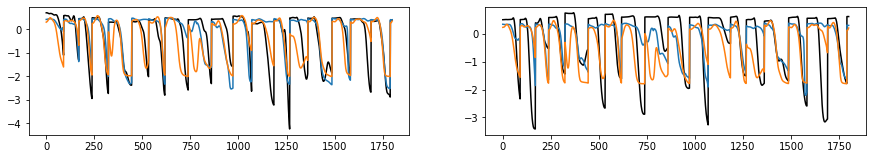

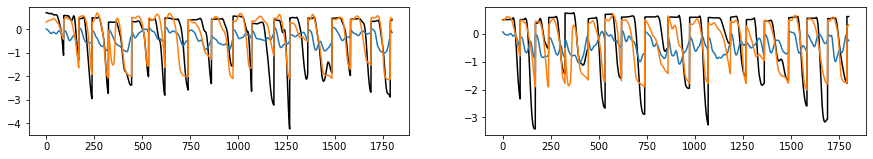

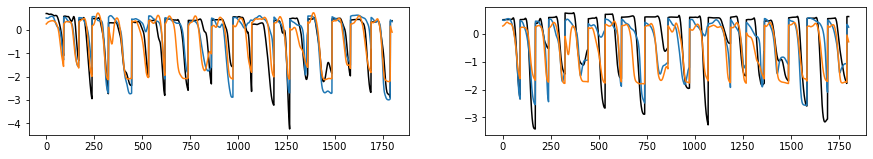

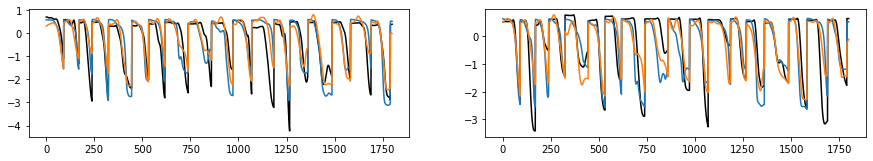

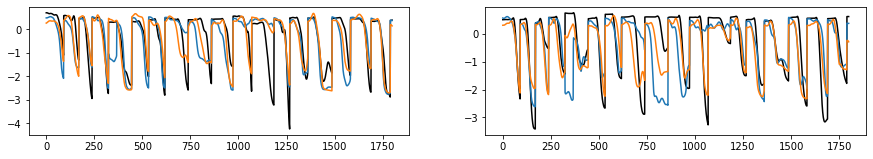

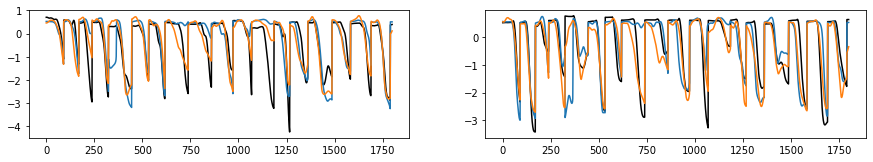

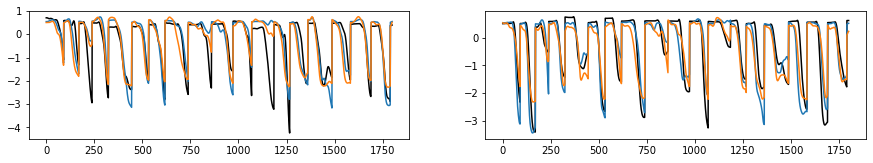

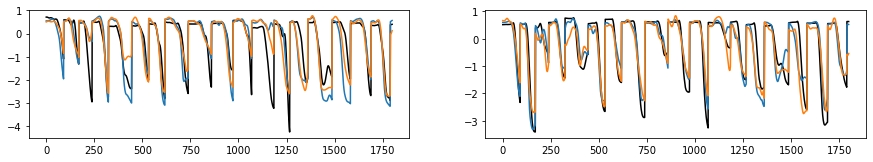

In [13]:
bounds = list(range(0,1800))

for num_neuron in num_neuron_list:
    plt.figure(figsize=(15,8))
    for mrk_idx in range(2):
        plt.subplot(3,2,mrk_idx+1)
        plt.plot(y_test_data[bounds,mrk_idx], color='k')
        plt.plot(num_neuron_results_dict[f'num_neuron_{num_neuron}']['rnn']['notask']['test_pred'][bounds,mrk_idx])
        plt.plot(num_neuron_results_dict[f'num_neuron_{num_neuron}']['rnn']['task']['test_pred'][bounds,mrk_idx])


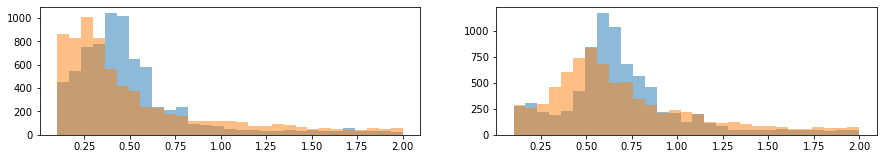

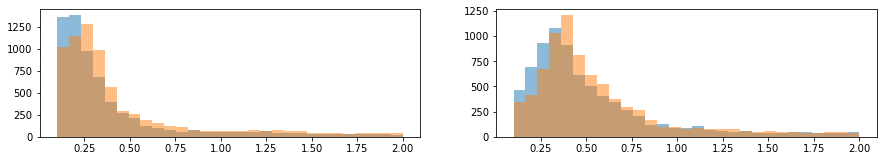

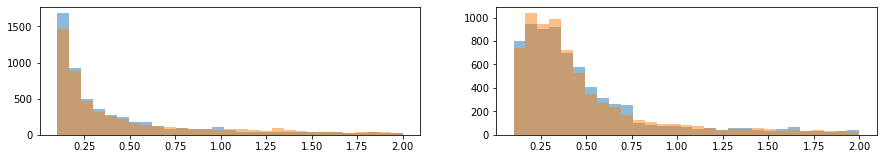

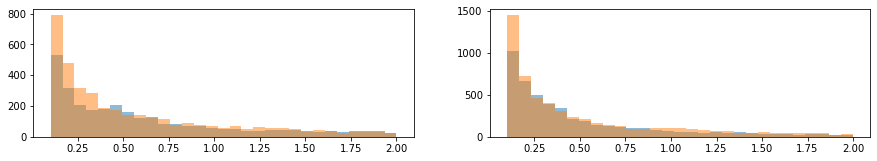

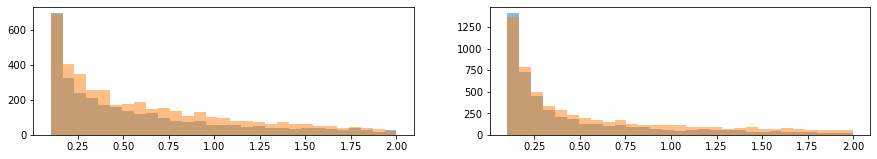

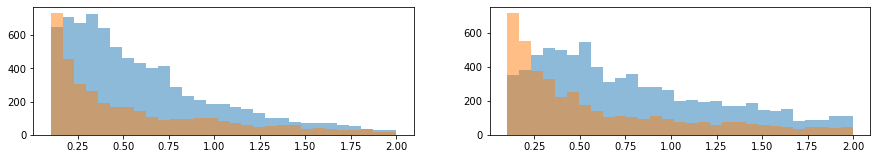

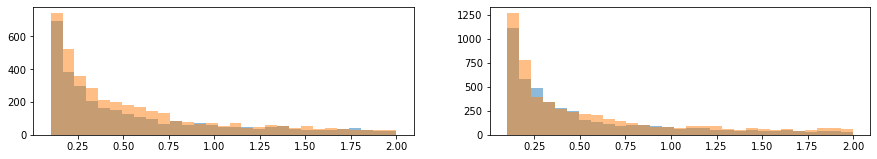

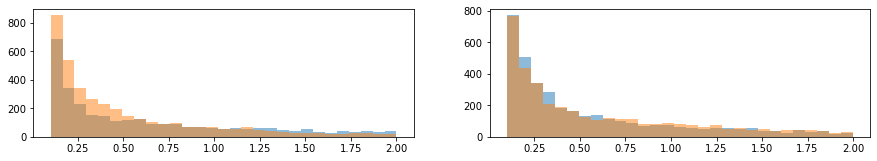

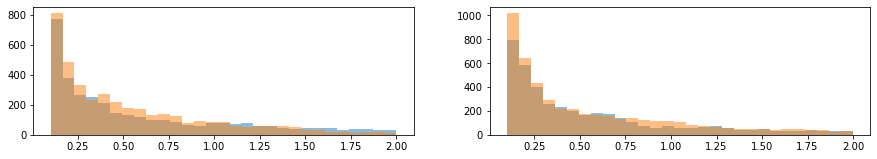

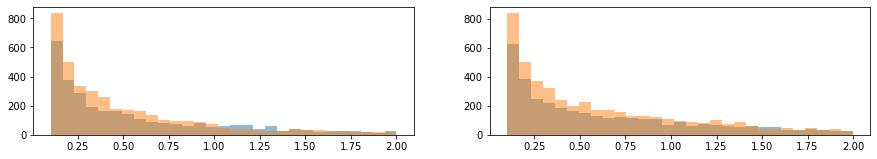

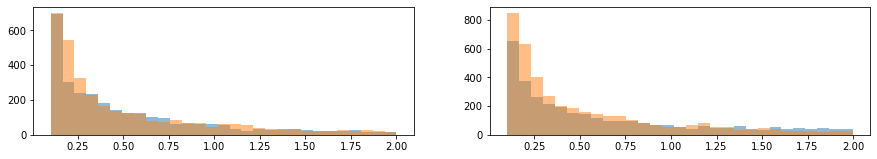

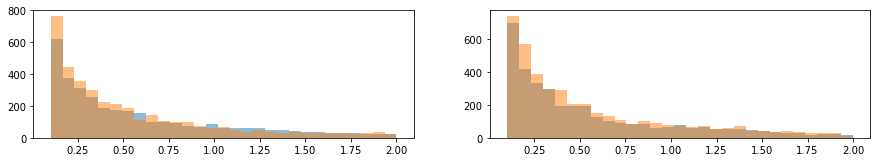

In [14]:
for num_neuron in num_neuron_list:
    bins = np.linspace(0.1, 2, 30)
    plt.figure(figsize=(15,8))
    for mrk_idx in range(2):
        plt.subplot(3,2,mrk_idx+1)

        notask_mse = np.square(num_neuron_results_dict[f'num_neuron_{num_neuron}']['rnn']['notask']['test_pred'][:,mrk_idx] - y_test_data[:,mrk_idx])
        task_mse = np.square(num_neuron_results_dict[f'num_neuron_{num_neuron}']['rnn']['task']['test_pred'][:,mrk_idx] - y_test_data[:,mrk_idx])

        plt.hist(notask_mse, bins=bins, alpha=0.5)
        plt.hist(task_mse, bins=bins, alpha=0.5)


KeyError: 'num_neuron_30'

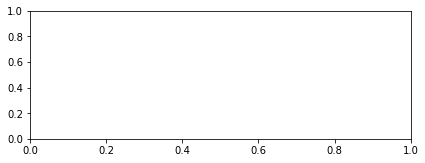

In [13]:
for label_idx in range(1,5):
    label_mask = test_labels == label_idx
    
    plt.figure(figsize=(15,8))
    for mrk_idx in range(2):
        plt.subplot(3,2,mrk_idx+1)


        notask_mse = np.square(num_neuron_results_dict[
            f'num_neuron_30']['rnn']['notask']['test_pred'][label_mask,mrk_idx] - y_test_data[label_mask,mrk_idx])
        task_mse = np.square(num_neuron_results_dict[
            f'num_neuron_30']['rnn']['task']['test_pred'][label_mask,mrk_idx] - y_test_data[label_mask,mrk_idx])

         

        plt.hist(notask_mse, bins=bins, alpha=0.5)
        plt.hist(task_mse, bins=bins, alpha=0.5)

        plt.suptitle(f'label {label_idx}')



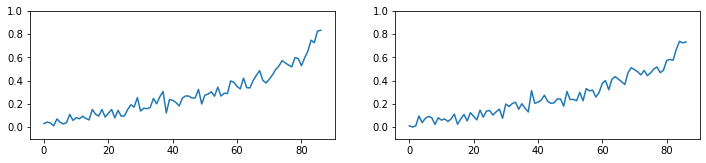

In [53]:
notask_corr_sort = unit_corr_array[sort_indices, :]

plt.figure(figsize=(12, 8))
for plot_idx in range(2):
    plt.subplot(3,2,plot_idx+1)
    plt.plot(notask_corr_sort[:, plot_idx])

    plt.ylim(-0.1, 1)

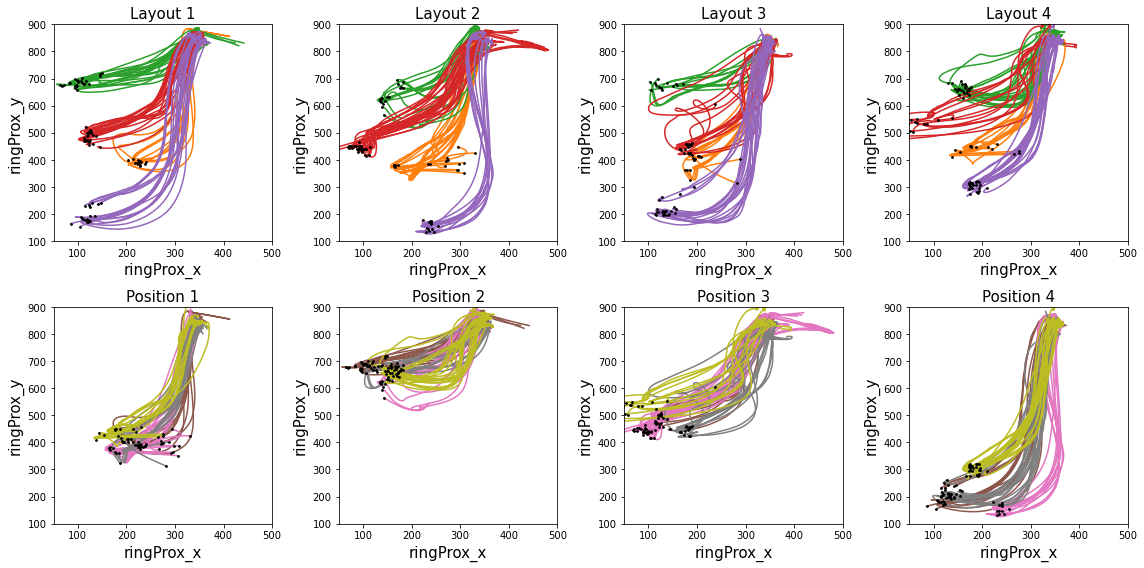

In [3]:
marker_name = 'ringProx'

plt.figure(figsize=(16,8))
fontsize=15

xmin, xmax = 50, 500
ymin, ymax =  100, 900

for position_idx in range(1,5):
    for layout_idx in range(1,5):
        plt.subplot(2,4,layout_idx)
        mask = np.logical_and(wrist_df['position'] == position_idx, wrist_df['layout'] == layout_idx)
        filtered_df = wrist_df[mask]

        x_data =  filtered_df[filtered_df['name'] == f'{marker_name}_x']['posData'].values
        y_data =  filtered_df[filtered_df['name'] == f'{marker_name}_y']['posData'].values

        for plot_data in zip(x_data, y_data):
            plt.scatter(plot_data[0][-1], plot_data[1][-1], color='k', zorder=10, s=3)
            plt.plot(plot_data[0], plot_data[1], color=f'C{position_idx}')

        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)

        plt.xlabel(f'{marker_name}_x', fontsize=fontsize)
        plt.ylabel(f'{marker_name}_y', fontsize=fontsize)
        plt.title(f'Layout {layout_idx}', fontsize=fontsize)

        plt.subplot(2,4,position_idx + 4)
        for plot_data in zip(x_data, y_data):
            plt.scatter(plot_data[0][-1], plot_data[1][-1], color='k', zorder=10, s=3)
            plt.plot(plot_data[0], plot_data[1], color=f'C{layout_idx + 4}')
    
        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)

        plt.xlabel(f'{marker_name}_x', fontsize=fontsize)
        plt.ylabel(f'{marker_name}_y', fontsize=fontsize)
        plt.title(f'Position {position_idx}', fontsize=fontsize)

plt.tight_layout()
        

In [55]:
def plot_trajectories(split_type='train_idx'):
    marker_name = 'ringProx'

    plt.figure(figsize=(16,8))
    fontsize=15

    xmin, xmax = 50, 500
    ymin, ymax =  100, 900

    trial_mask = np.in1d(wrist_df['trial'].values, cv_dict[data_dict['noise_fold']][split_type])
    trial_df = wrist_df[trial_mask]

    for position_idx in range(1,5):
        for layout_idx in range(1,5):
            plt.subplot(2,4,layout_idx)
            mask = np.logical_and(trial_df['position'] == position_idx, trial_df['layout'] == layout_idx)
            filtered_df = trial_df[mask]

            x_data =  filtered_df[filtered_df['name'] == f'{marker_name}_x']['posData'].values
            y_data =  filtered_df[filtered_df['name'] == f'{marker_name}_y']['posData'].values

            for plot_data in zip(x_data, y_data):
                plt.scatter(plot_data[0][-1], plot_data[1][-1], color='k', zorder=10, s=3)
                plt.plot(plot_data[0], plot_data[1], color=f'C{position_idx}')

            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)

            plt.xlabel(f'{marker_name}_x', fontsize=fontsize)
            plt.ylabel(f'{marker_name}_y', fontsize=fontsize)
            plt.title(f'Layout {layout_idx}', fontsize=fontsize)

            plt.subplot(2,4,position_idx + 4)
            for plot_data in zip(x_data, y_data):
                plt.scatter(plot_data[0][-1], plot_data[1][-1], color='k', zorder=10, s=3)
                plt.plot(plot_data[0], plot_data[1], color=f'C{layout_idx + 4}')
        
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)

            plt.xlabel(f'{marker_name}_x', fontsize=fontsize)
            plt.ylabel(f'{marker_name}_y', fontsize=fontsize)
            plt.title(f'Position {position_idx}', fontsize=fontsize)

    plt.tight_layout()
            

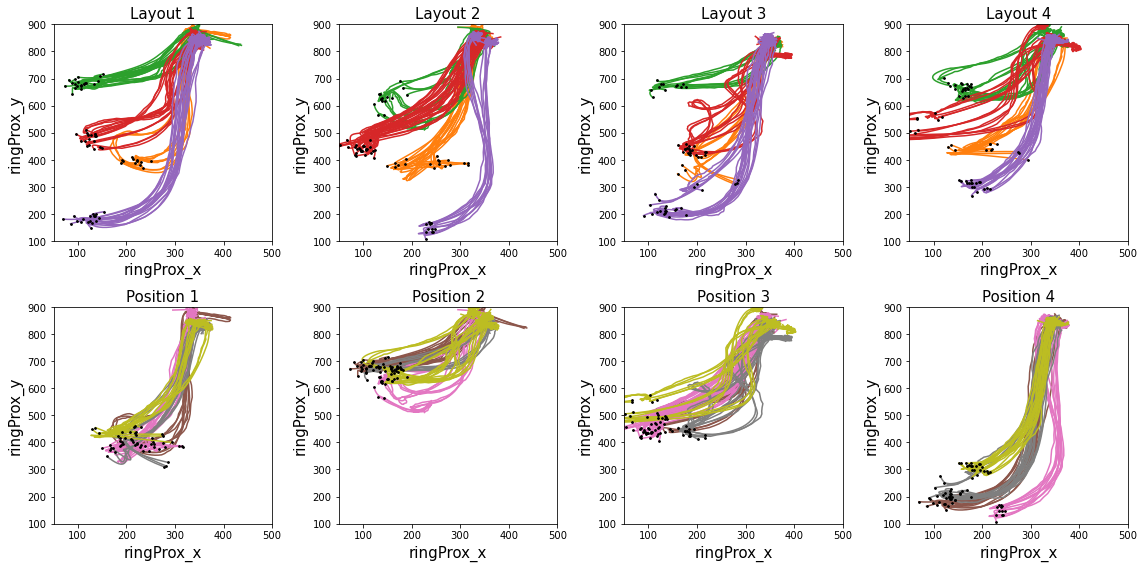

In [12]:
plot_trajectories('train_idx')

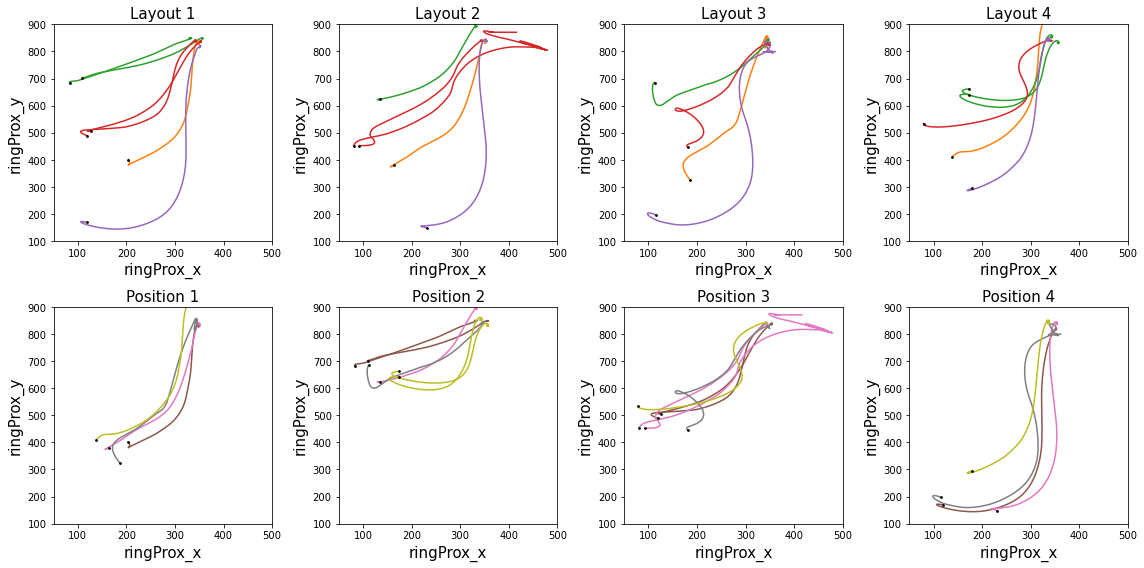

In [13]:
plot_trajectories('test_idx')

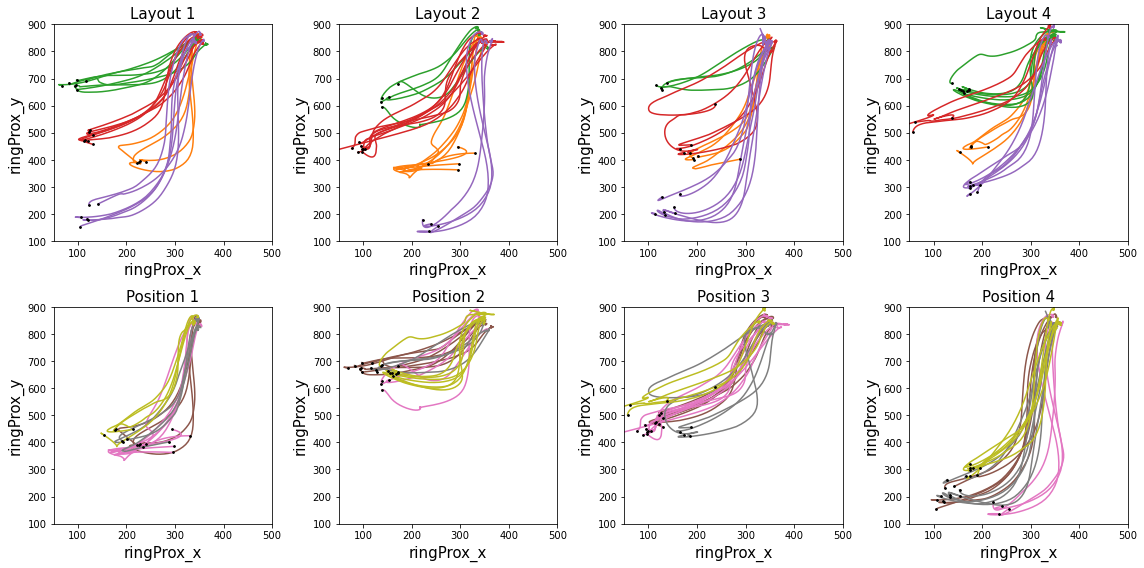

In [15]:
plot_trajectories('validation_idx')